In [ ]:
!pip install lightgbm optuna
!pip install optuna-integration[lightgbm]
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
from optuna.integration import LightGBMPruningCallback
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Senior_Thesis_Waseda/exp_sex')

In [ ]:
%run ../evaluation.ipynb
%run ../training.ipynb
%run ../parameter_optimization.ipynb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data.csv')
df.head()
df.shape

(97220, 82)

In [ ]:
income = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data_pre_cluster.csv')
income = income.loc[:, ['D_INTERVIEW','Q260']]
income.head()

,D_INTERVIEW,Q260
0,196070011,1
1,196070036,2
2,196070039,2
3,196070040,2
4,196070053,2


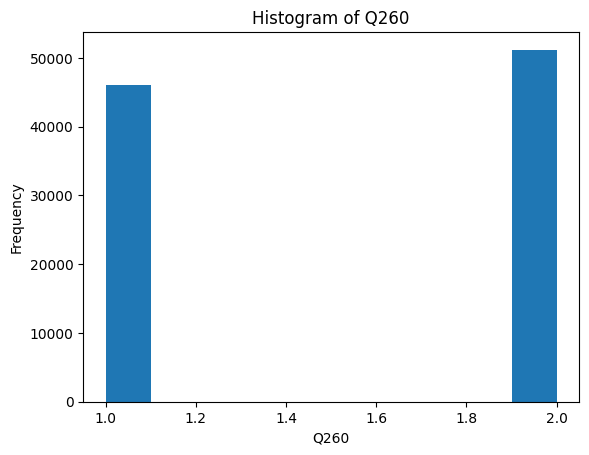

In [ ]:
import matplotlib.pyplot as plt

plt.hist(income['Q260'])
plt.xlabel('Q260')
plt.ylabel('Frequency')
plt.title('Histogram of Q260')
plt.show()

In [ ]:
df_merged = pd.merge(income, df, on='D_INTERVIEW')
df_merged.head()

,D_INTERVIEW,Q260,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,1,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,2,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,2,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,2,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,2,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
df_merged = df_merged[df_merged['Q260'] == 1]
df_merged.head()

,D_INTERVIEW,Q260,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,1,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
5,196070058,1,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.253464,-0.376054,0.679133,-0.112024,0.915767,0.884878,1,3,7,3
6,196070067,1,4.666667,CYP,6.0,1,4.0,-1.068037,-0.623011,0.764001,...,-1.092566,0.739553,0.976462,0.685612,0.323946,0.884878,1,1,9,3
8,196070070,1,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.321191,-0.332603,0.976462,-1.218074,-0.864383,-0.358720,1,2,8,3
10,196070154,1,8.666667,CYP,7.0,1,1.0,-1.068037,-0.623011,-1.308899,...,-0.999931,0.091762,0.098696,-0.266231,-1.456204,0.884878,1,6,8,3


In [ ]:
categorical = ['Cl_73', 'Cl_74', 'Cl_75', 'Cl_76']

for col in categorical:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [ ]:
X = df_merged.loc[:, 'Cl_1':]
y = df_merged['happiness']

In [ ]:
parameter_optimization(X, y,
    save_path="exp_male_best_params.json")

[I 2025-06-15 05:56:54,758] A new study created in memory with name: lgbm_regression_opt


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.555016
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.559636
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.54408
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.537094
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.539599


[I 2025-06-15 06:02:16,433] Trial 0 finished with value: 0.5470849410029599 and parameters: {'num_leaves': 37, 'learning_rate': 0.059662768998574464, 'max_depth': 12, 'reg_alpha': 0.01689821456403644, 'reg_lambda': 0.008733286960935062, 'feature_fraction': 0.5545578611806954, 'bagging_fraction': 0.7944205512826226, 'bagging_freq': 4, 'min_data_in_leaf': 483}. Best is trial 0 with value: 0.5470849410029599.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.593879
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.594265
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.582548
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.574067
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.576786


[I 2025-06-15 06:09:41,400] Trial 1 finished with value: 0.584309129813589 and parameters: {'num_leaves': 124, 'learning_rate': 0.008135993077935482, 'max_depth': 11, 'reg_alpha': 0.00016165526881359486, 'reg_lambda': 0.7035409156988579, 'feature_fraction': 0.4019026700531766, 'bagging_fraction': 0.5756856352296862, 'bagging_freq': 5, 'min_data_in_leaf': 459}. Best is trial 0 with value: 0.5470849410029599.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.03896
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.03813
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.03434
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.0258
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.02851


[I 2025-06-15 06:17:44,662] Trial 2 finished with value: 1.0331500075625262 and parameters: {'num_leaves': 59, 'learning_rate': 0.0031419355583659327, 'max_depth': 9, 'reg_alpha': 8.662924996503568, 'reg_lambda': 0.02194583099502228, 'feature_fraction': 0.47397242771581266, 'bagging_fraction': 0.9496188320394634, 'bagging_freq': 7, 'min_data_in_leaf': 153}. Best is trial 0 with value: 0.5470849410029599.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.5232
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.5333
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.52675
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51949
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51886


[I 2025-06-15 06:22:16,704] Trial 3 finished with value: 1.5243173167845119 and parameters: {'num_leaves': 88, 'learning_rate': 0.0020393416894354194, 'max_depth': 3, 'reg_alpha': 0.004180382606157517, 'reg_lambda': 9.005175761589022, 'feature_fraction': 0.7078847726835956, 'bagging_fraction': 0.9258973847512997, 'bagging_freq': 1, 'min_data_in_leaf': 156}. Best is trial 0 with value: 0.5470849410029599.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.551296
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.557736
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.540729
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.533769
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.535819


[I 2025-06-15 06:31:48,678] Trial 4 finished with value: 0.5438699978838524 and parameters: {'num_leaves': 81, 'learning_rate': 0.03338461566965746, 'max_depth': 12, 'reg_alpha': 0.009228237972087388, 'reg_lambda': 4.420164028591646, 'feature_fraction': 0.6997672062599631, 'bagging_fraction': 0.8812298141809676, 'bagging_freq': 7, 'min_data_in_leaf': 251}. Best is trial 4 with value: 0.5438699978838524.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.05275
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.05453
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.04917
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.04008
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.04181


[I 2025-06-15 06:39:42,838] Trial 5 finished with value: 1.0476675366227988 and parameters: {'num_leaves': 131, 'learning_rate': 0.0035756793567883233, 'max_depth': 6, 'reg_alpha': 0.0003352532574306502, 'reg_lambda': 0.04127989591553768, 'feature_fraction': 0.7891048128108265, 'bagging_fraction': 0.9397669501941917, 'bagging_freq': 1, 'min_data_in_leaf': 169}. Best is trial 4 with value: 0.5438699978838524.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.559682
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.564081
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.548289
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.543397
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.543875


[I 2025-06-15 06:44:13,734] Trial 6 finished with value: 0.5518648877990794 and parameters: {'num_leaves': 30, 'learning_rate': 0.07511737052942642, 'max_depth': 12, 'reg_alpha': 0.0009040884568982261, 'reg_lambda': 5.889870175124454, 'feature_fraction': 0.6664289643882277, 'bagging_fraction': 0.5580546342887509, 'bagging_freq': 5, 'min_data_in_leaf': 200}. Best is trial 4 with value: 0.5438699978838524.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.548936
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.555242
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.540038
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.531407
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.533257


[I 2025-06-15 06:55:23,810] Trial 7 finished with value: 0.5417760999405594 and parameters: {'num_leaves': 149, 'learning_rate': 0.021584729121977998, 'max_depth': 12, 'reg_alpha': 7.376024827825465, 'reg_lambda': 0.0008077586571489891, 'feature_fraction': 0.6648231984664661, 'bagging_fraction': 0.8036760300859622, 'bagging_freq': 5, 'min_data_in_leaf': 204}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.558365
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.562057
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.550307
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.541876
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.540118


[I 2025-06-15 07:02:56,843] Trial 8 finished with value: 0.5505447492195898 and parameters: {'num_leaves': 107, 'learning_rate': 0.027521448316098446, 'max_depth': 10, 'reg_alpha': 0.004026360901338699, 'reg_lambda': 0.000305705563511273, 'feature_fraction': 0.9006505683344346, 'bagging_fraction': 0.4151335109209015, 'bagging_freq': 2, 'min_data_in_leaf': 432}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.33383
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.33639
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.33483
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.32655
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.32697


[I 2025-06-15 07:08:23,948] Trial 9 finished with value: 1.3317121232793934 and parameters: {'num_leaves': 26, 'learning_rate': 0.0024446594456802922, 'max_depth': 7, 'reg_alpha': 0.001499402648929466, 'reg_lambda': 0.006244650388242344, 'feature_fraction': 0.4870981102803031, 'bagging_fraction': 0.4813828127928418, 'bagging_freq': 1, 'min_data_in_leaf': 92}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:08:36,828] Trial 10 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.555543
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.558559
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.545296
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.535801
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.536423


[I 2025-06-15 07:17:12,485] Trial 11 finished with value: 0.5463244367749637 and parameters: {'num_leaves': 72, 'learning_rate': 0.028114034068820244, 'max_depth': 9, 'reg_alpha': 0.18049197303944922, 'reg_lambda': 0.34512409552326406, 'feature_fraction': 0.6296645942023187, 'bagging_fraction': 0.819810144023043, 'bagging_freq': 7, 'min_data_in_leaf': 284}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:17:30,357] Trial 12 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:18:22,680] Trial 13 pruned. Trial was pruned at iteration 253.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:18:39,763] Trial 14 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:19:01,141] Trial 15 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.552301
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.558044
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.544258
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.536319
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.539297


[I 2025-06-15 07:28:30,215] Trial 16 finished with value: 0.5460435230520464 and parameters: {'num_leaves': 54, 'learning_rate': 0.04521189109160477, 'max_depth': 10, 'reg_alpha': 0.010061145548751751, 'reg_lambda': 1.7087530489429836, 'feature_fraction': 0.8624086565552432, 'bagging_fraction': 0.9987561539929737, 'bagging_freq': 4, 'min_data_in_leaf': 355}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:28:37,921] Trial 17 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:28:55,153] Trial 18 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:29:07,794] Trial 19 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:29:19,972] Trial 20 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.552512
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.558073
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.544936
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.536556
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.537815


[I 2025-06-15 07:38:39,185] Trial 21 finished with value: 0.5459785037590539 and parameters: {'num_leaves': 55, 'learning_rate': 0.050320029292541466, 'max_depth': 10, 'reg_alpha': 0.013541903284479176, 'reg_lambda': 2.9808172606637657, 'feature_fraction': 0.8625946133430225, 'bagging_fraction': 0.9915500873956528, 'bagging_freq': 4, 'min_data_in_leaf': 335}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.553067
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.559838
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.544419
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.538099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.539856


[I 2025-06-15 07:46:59,587] Trial 22 finished with value: 0.5470556559796871 and parameters: {'num_leaves': 47, 'learning_rate': 0.048607942708221996, 'max_depth': 12, 'reg_alpha': 0.009950371885928712, 'reg_lambda': 1.7314256442587344, 'feature_fraction': 0.7317568327460714, 'bagging_fraction': 0.9955000658166588, 'bagging_freq': 3, 'min_data_in_leaf': 218}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.551159
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.554975
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.54142
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.532094
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.533502


[I 2025-06-15 07:56:30,206] Trial 23 finished with value: 0.5426301910878452 and parameters: {'num_leaves': 80, 'learning_rate': 0.039627607194371806, 'max_depth': 11, 'reg_alpha': 0.025480544733029607, 'reg_lambda': 0.19622696556823904, 'feature_fraction': 0.6714426247822578, 'bagging_fraction': 0.897540245644601, 'bagging_freq': 4, 'min_data_in_leaf': 315}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.552763
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.556478
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.541663
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.532246
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.534124


[I 2025-06-15 08:05:27,172] Trial 24 finished with value: 0.5434547101961285 and parameters: {'num_leaves': 82, 'learning_rate': 0.033524004719281825, 'max_depth': 11, 'reg_alpha': 0.0369858494976444, 'reg_lambda': 0.1526582710659118, 'feature_fraction': 0.6735213089463983, 'bagging_fraction': 0.7500665176846019, 'bagging_freq': 4, 'min_data_in_leaf': 273}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:05:43,154] Trial 25 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:05:59,573] Trial 26 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:06:13,960] Trial 27 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.550697
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.554832
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.540187
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.534436
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.534491


[I 2025-06-15 08:13:57,699] Trial 28 finished with value: 0.5429286392281141 and parameters: {'num_leaves': 115, 'learning_rate': 0.038579318757018116, 'max_depth': 9, 'reg_alpha': 0.3126699218251819, 'reg_lambda': 0.8928894286434175, 'feature_fraction': 0.6678311264157466, 'bagging_fraction': 0.646938326350541, 'bagging_freq': 5, 'min_data_in_leaf': 126}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid's rmse: 0.552386
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid's rmse: 0.556293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid's rmse: 0.541435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[330]	valid's rmse: 0.538287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	valid's rmse: 0.536845


[I 2025-06-15 08:19:45,963] Trial 29 finished with value: 0.5450492964046413 and parameters: {'num_leaves': 139, 'learning_rate': 0.05981956482151484, 'max_depth': 9, 'reg_alpha': 0.3507040431297707, 'reg_lambda': 0.9543697313318954, 'feature_fraction': 0.7463676233375822, 'bagging_fraction': 0.6077680619057052, 'bagging_freq': 5, 'min_data_in_leaf': 107}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[464]	valid's rmse: 0.554253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[427]	valid's rmse: 0.558788
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.545769
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.53585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid's rmse: 0.54044


[I 2025-06-15 08:25:20,206] Trial 30 finished with value: 0.547020069870655 and parameters: {'num_leaves': 118, 'learning_rate': 0.07242936507347188, 'max_depth': 7, 'reg_alpha': 0.11981086383740595, 'reg_lambda': 0.008153788859432229, 'feature_fraction': 0.5276163634084458, 'bagging_fraction': 0.6450094713782712, 'bagging_freq': 5, 'min_data_in_leaf': 58}. Best is trial 7 with value: 0.5417760999405594.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.548365
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.554166
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.538841
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[474]	valid's rmse: 0.530764
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.532136


[I 2025-06-15 08:34:39,441] Trial 31 finished with value: 0.5408544418155998 and parameters: {'num_leaves': 110, 'learning_rate': 0.03883254941022102, 'max_depth': 12, 'reg_alpha': 0.02194319907546842, 'reg_lambda': 0.8292524350675762, 'feature_fraction': 0.6764850541396563, 'bagging_fraction': 0.7947859636932336, 'bagging_freq': 4, 'min_data_in_leaf': 131}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid's rmse: 0.550137
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.555822
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.53929
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.53069
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.535233


[I 2025-06-15 08:43:23,661] Trial 32 finished with value: 0.5422344657384759 and parameters: {'num_leaves': 110, 'learning_rate': 0.0373446662489069, 'max_depth': 12, 'reg_alpha': 0.02548211134120514, 'reg_lambda': 0.5370838997049154, 'feature_fraction': 0.684949365023741, 'bagging_fraction': 0.683310867143159, 'bagging_freq': 4, 'min_data_in_leaf': 125}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:43:41,144] Trial 33 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:44:01,673] Trial 34 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:44:19,816] Trial 35 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.547904
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[481]	valid's rmse: 0.554741
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.541119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[378]	valid's rmse: 0.531634
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.535153


[I 2025-06-15 08:51:07,020] Trial 36 finished with value: 0.5421101367454643 and parameters: {'num_leaves': 91, 'learning_rate': 0.05993772725656536, 'max_depth': 12, 'reg_alpha': 0.02296368693680685, 'reg_lambda': 0.019545196176309263, 'feature_fraction': 0.4343020060399768, 'bagging_fraction': 0.8481277575365034, 'bagging_freq': 3, 'min_data_in_leaf': 134}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[409]	valid's rmse: 0.550695
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[434]	valid's rmse: 0.553139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid's rmse: 0.541518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid's rmse: 0.532063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid's rmse: 0.536864


[I 2025-06-15 08:57:39,414] Trial 37 finished with value: 0.5428556717419294 and parameters: {'num_leaves': 110, 'learning_rate': 0.06733452221409746, 'max_depth': 12, 'reg_alpha': 0.09169622682283668, 'reg_lambda': 0.01579008440710105, 'feature_fraction': 0.4104501267831502, 'bagging_fraction': 0.8447679099295444, 'bagging_freq': 2, 'min_data_in_leaf': 147}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[233]	valid's rmse: 0.553914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid's rmse: 0.561568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid's rmse: 0.547125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid's rmse: 0.540258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[209]	valid's rmse: 0.541247


[I 2025-06-15 09:01:10,611] Trial 38 finished with value: 0.5488224099196553 and parameters: {'num_leaves': 122, 'learning_rate': 0.09891335580979656, 'max_depth': 12, 'reg_alpha': 0.023851910250071124, 'reg_lambda': 0.0029272358005342255, 'feature_fraction': 0.4414904984639486, 'bagging_fraction': 0.553444607268401, 'bagging_freq': 3, 'min_data_in_leaf': 163}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.550489
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[482]	valid's rmse: 0.557914
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[471]	valid's rmse: 0.543806
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.534511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	valid's rmse: 0.536009


[I 2025-06-15 09:08:15,406] Trial 39 finished with value: 0.5445456881762217 and parameters: {'num_leaves': 93, 'learning_rate': 0.05508927296916233, 'max_depth': 10, 'reg_alpha': 0.006073674313997645, 'reg_lambda': 0.000516976639463768, 'feature_fraction': 0.5467967422458947, 'bagging_fraction': 0.7764291324669271, 'bagging_freq': 3, 'min_data_in_leaf': 41}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[178]	valid's rmse: 0.555408
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid's rmse: 0.557783
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[292]	valid's rmse: 0.546516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid's rmse: 0.535709
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid's rmse: 0.537359


[I 2025-06-15 09:12:37,057] Trial 40 finished with value: 0.5465548256285281 and parameters: {'num_leaves': 130, 'learning_rate': 0.08155760812245752, 'max_depth': 12, 'reg_alpha': 0.0005947212028885498, 'reg_lambda': 0.00011243702863623463, 'feature_fraction': 0.493229409761046, 'bagging_fraction': 0.6906362820258112, 'bagging_freq': 2, 'min_data_in_leaf': 87}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.550376
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.556373
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.540234
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.532662
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.536584


[I 2025-06-15 09:21:49,587] Trial 41 finished with value: 0.5432456789671172 and parameters: {'num_leaves': 79, 'learning_rate': 0.04173700715142142, 'max_depth': 11, 'reg_alpha': 0.03087412970460405, 'reg_lambda': 0.19721964795274938, 'feature_fraction': 0.7025533207930494, 'bagging_fraction': 0.9006711456131986, 'bagging_freq': 4, 'min_data_in_leaf': 207}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:22:09,336] Trial 42 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[449]	valid's rmse: 0.550653
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.557605
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.541115
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.532495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[438]	valid's rmse: 0.536124


[I 2025-06-15 09:31:29,659] Trial 43 finished with value: 0.5435983023462416 and parameters: {'num_leaves': 108, 'learning_rate': 0.03816360401936979, 'max_depth': 12, 'reg_alpha': 0.019418353598263674, 'reg_lambda': 0.05493177877849149, 'feature_fraction': 0.7496530868714613, 'bagging_fraction': 0.7323006006995983, 'bagging_freq': 4, 'min_data_in_leaf': 165}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.550436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[328]	valid's rmse: 0.556645
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[383]	valid's rmse: 0.540222
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid's rmse: 0.532958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[393]	valid's rmse: 0.538397


[I 2025-06-15 09:38:36,362] Trial 44 finished with value: 0.5437316768653349 and parameters: {'num_leaves': 100, 'learning_rate': 0.06254895838378952, 'max_depth': 11, 'reg_alpha': 0.00019053400640416392, 'reg_lambda': 1.5018357603325414, 'feature_fraction': 0.566321204972447, 'bagging_fraction': 0.8177199272378337, 'bagging_freq': 5, 'min_data_in_leaf': 221}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:38:54,003] Trial 45 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:39:12,295] Trial 46 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:39:28,220] Trial 47 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:39:48,637] Trial 48 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:40:08,043] Trial 49 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	valid's rmse: 0.553012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid's rmse: 0.558293
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.545396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid's rmse: 0.536542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[358]	valid's rmse: 0.538019


[I 2025-06-15 09:45:13,500] Trial 50 finished with value: 0.5462524044297811 and parameters: {'num_leaves': 76, 'learning_rate': 0.08058851755601343, 'max_depth': 10, 'reg_alpha': 0.03239516424201198, 'reg_lambda': 0.09605124012282418, 'feature_fraction': 0.46011099117189364, 'bagging_fraction': 0.7152981204156615, 'bagging_freq': 3, 'min_data_in_leaf': 111}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[436]	valid's rmse: 0.549054
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[458]	valid's rmse: 0.554471
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[470]	valid's rmse: 0.539982
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[456]	valid's rmse: 0.530625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[393]	valid's rmse: 0.534377


[I 2025-06-15 09:52:38,123] Trial 51 finished with value: 0.5417018065905991 and parameters: {'num_leaves': 114, 'learning_rate': 0.06690244433124622, 'max_depth': 12, 'reg_alpha': 0.07907929263761276, 'reg_lambda': 0.004190754570500836, 'feature_fraction': 0.4029337269385212, 'bagging_fraction': 0.8471860383005986, 'bagging_freq': 2, 'min_data_in_leaf': 148}. Best is trial 31 with value: 0.5408544418155998.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.546775
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.553528
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[469]	valid's rmse: 0.539989
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.529969
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid's rmse: 0.53333


[I 2025-06-15 09:58:53,421] Trial 52 finished with value: 0.5407182513628906 and parameters: {'num_leaves': 111, 'learning_rate': 0.05035524192082447, 'max_depth': 12, 'reg_alpha': 5.434643176108656, 'reg_lambda': 0.000987135761853697, 'feature_fraction': 0.4106431365830043, 'bagging_fraction': 0.771819762961625, 'bagging_freq': 1, 'min_data_in_leaf': 147}. Best is trial 52 with value: 0.5407182513628906.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.546988
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.552237
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.539349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.530119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid's rmse: 0.531987


[I 2025-06-15 10:05:06,597] Trial 53 finished with value: 0.5401359515898306 and parameters: {'num_leaves': 113, 'learning_rate': 0.05437830838956305, 'max_depth': 12, 'reg_alpha': 8.850294922054985, 'reg_lambda': 0.0007283408966518508, 'feature_fraction': 0.4050866432281324, 'bagging_fraction': 0.7734055220262124, 'bagging_freq': 1, 'min_data_in_leaf': 145}. Best is trial 53 with value: 0.5401359515898306.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:05:14,216] Trial 54 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.548292
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid's rmse: 0.553208
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.540162
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.528796
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[297]	valid's rmse: 0.534465


[I 2025-06-15 10:11:29,089] Trial 55 finished with value: 0.5409846410980271 and parameters: {'num_leaves': 128, 'learning_rate': 0.05955103612118874, 'max_depth': 12, 'reg_alpha': 5.3773315859382915, 'reg_lambda': 0.002368359871334058, 'feature_fraction': 0.43795435803440286, 'bagging_fraction': 0.804385399791451, 'bagging_freq': 1, 'min_data_in_leaf': 200}. Best is trial 53 with value: 0.5401359515898306.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[348]	valid's rmse: 0.549919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid's rmse: 0.556499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[391]	valid's rmse: 0.541564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	valid's rmse: 0.533121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid's rmse: 0.535902


[I 2025-06-15 10:16:50,657] Trial 56 finished with value: 0.543401118876967 and parameters: {'num_leaves': 131, 'learning_rate': 0.07653119990775854, 'max_depth': 11, 'reg_alpha': 5.189660714810508, 'reg_lambda': 0.00023277598613924134, 'feature_fraction': 0.48683294048744824, 'bagging_fraction': 0.7828699865529277, 'bagging_freq': 1, 'min_data_in_leaf': 204}. Best is trial 53 with value: 0.5401359515898306.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:17:01,750] Trial 57 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:17:15,491] Trial 58 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid's rmse: 0.551611
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid's rmse: 0.55724
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	valid's rmse: 0.5431
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[251]	valid's rmse: 0.533713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid's rmse: 0.536297


[I 2025-06-15 10:22:10,674] Trial 59 finished with value: 0.5443921834110401 and parameters: {'num_leaves': 114, 'learning_rate': 0.08867653154636554, 'max_depth': 11, 'reg_alpha': 1.161016104321952, 'reg_lambda': 0.0037756640658646247, 'feature_fraction': 0.46789613407494246, 'bagging_fraction': 0.8298401839376468, 'bagging_freq': 1, 'min_data_in_leaf': 201}. Best is trial 53 with value: 0.5401359515898306.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[480]	valid's rmse: 0.548172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid's rmse: 0.555724
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid's rmse: 0.540535
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid's rmse: 0.53049
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[328]	valid's rmse: 0.535327


[I 2025-06-15 10:28:29,372] Trial 60 finished with value: 0.5420496696943503 and parameters: {'num_leaves': 136, 'learning_rate': 0.06886499092487162, 'max_depth': 11, 'reg_alpha': 2.811548009283859, 'reg_lambda': 0.0013432479791663783, 'feature_fraction': 0.4479891949964074, 'bagging_fraction': 0.740487015247651, 'bagging_freq': 2, 'min_data_in_leaf': 168}. Best is trial 53 with value: 0.5401359515898306.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[391]	valid's rmse: 0.549362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid's rmse: 0.555316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid's rmse: 0.540576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid's rmse: 0.530744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid's rmse: 0.535793


[I 2025-06-15 10:34:43,950] Trial 61 finished with value: 0.5423581545283509 and parameters: {'num_leaves': 135, 'learning_rate': 0.06513624965261386, 'max_depth': 12, 'reg_alpha': 2.9680421494439506, 'reg_lambda': 0.0014415312129736869, 'feature_fraction': 0.44977596539650083, 'bagging_fraction': 0.7297278932937146, 'bagging_freq': 2, 'min_data_in_leaf': 164}. Best is trial 53 with value: 0.5401359515898306.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[461]	valid's rmse: 0.547162
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.551572
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.538002
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.527738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[395]	valid's rmse: 0.531115


[I 2025-06-15 10:43:14,546] Trial 62 finished with value: 0.5391180609841519 and parameters: {'num_leaves': 146, 'learning_rate': 0.04469971526036904, 'max_depth': 11, 'reg_alpha': 5.527422353516034, 'reg_lambda': 0.0004061843794866804, 'feature_fraction': 0.4927731860045378, 'bagging_fraction': 0.7998151272855735, 'bagging_freq': 2, 'min_data_in_leaf': 104}. Best is trial 62 with value: 0.5391180609841519.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:43:27,975] Trial 63 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[439]	valid's rmse: 0.545829
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.551898
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.536463
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[380]	valid's rmse: 0.528905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[447]	valid's rmse: 0.532161


[I 2025-06-15 10:52:17,843] Trial 64 finished with value: 0.5390511943817219 and parameters: {'num_leaves': 149, 'learning_rate': 0.04525545460095845, 'max_depth': 12, 'reg_alpha': 1.7609353918103325, 'reg_lambda': 0.00043165904182478624, 'feature_fraction': 0.511349016850887, 'bagging_fraction': 0.8731399601417684, 'bagging_freq': 2, 'min_data_in_leaf': 85}. Best is trial 64 with value: 0.5390511943817219.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.545532
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.551854
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[480]	valid's rmse: 0.536476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid's rmse: 0.528677
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[428]	valid's rmse: 0.530623


[I 2025-06-15 11:01:17,379] Trial 65 finished with value: 0.5386324897922455 and parameters: {'num_leaves': 147, 'learning_rate': 0.04600287750432585, 'max_depth': 12, 'reg_alpha': 4.109126909770732, 'reg_lambda': 0.0004920618798482176, 'feature_fraction': 0.5025811955903194, 'bagging_fraction': 0.881224031025594, 'bagging_freq': 2, 'min_data_in_leaf': 91}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.548592
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.551165
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.539804
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.531925
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.53466


[I 2025-06-15 11:08:02,328] Trial 66 finished with value: 0.5412290593880333 and parameters: {'num_leaves': 147, 'learning_rate': 0.045764391522052285, 'max_depth': 11, 'reg_alpha': 1.5388815343638218, 'reg_lambda': 0.0004153006363133011, 'feature_fraction': 0.5050136490254208, 'bagging_fraction': 0.8692430548511637, 'bagging_freq': 1, 'min_data_in_leaf': 21}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:08:19,062] Trial 67 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid's rmse: 0.547603
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.553414
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.538956
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid's rmse: 0.528073
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[429]	valid's rmse: 0.530969


[I 2025-06-15 11:14:40,223] Trial 68 finished with value: 0.5398028165936795 and parameters: {'num_leaves': 143, 'learning_rate': 0.053889721628466565, 'max_depth': 10, 'reg_alpha': 8.544520639668473, 'reg_lambda': 0.0006315683618328366, 'feature_fraction': 0.47327783491832254, 'bagging_fraction': 0.7607261407779565, 'bagging_freq': 1, 'min_data_in_leaf': 51}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:14:55,061] Trial 69 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[481]	valid's rmse: 0.546168
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.551571
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.537759
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.52829
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.533254


[I 2025-06-15 11:22:04,702] Trial 70 finished with value: 0.5394085948062645 and parameters: {'num_leaves': 134, 'learning_rate': 0.04629967569323811, 'max_depth': 11, 'reg_alpha': 9.942593862226706, 'reg_lambda': 0.0003247280001025746, 'feature_fraction': 0.46973259114772403, 'bagging_fraction': 0.8837576507522787, 'bagging_freq': 1, 'min_data_in_leaf': 66}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid's rmse: 0.547884
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.552454
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.54002
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.527605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[389]	valid's rmse: 0.530988


[I 2025-06-15 11:28:51,263] Trial 71 finished with value: 0.539790266553438 and parameters: {'num_leaves': 136, 'learning_rate': 0.053433321248416515, 'max_depth': 10, 'reg_alpha': 8.327633969409638, 'reg_lambda': 0.0002781355644905293, 'feature_fraction': 0.4827637639863191, 'bagging_fraction': 0.716379083152861, 'bagging_freq': 1, 'min_data_in_leaf': 73}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.547139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid's rmse: 0.552093
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.537882
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.528034
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.532876


[I 2025-06-15 11:35:29,879] Trial 72 finished with value: 0.5396048304249258 and parameters: {'num_leaves': 135, 'learning_rate': 0.05368329559510361, 'max_depth': 10, 'reg_alpha': 8.410002719736834, 'reg_lambda': 0.000316664236439356, 'feature_fraction': 0.47698253843689664, 'bagging_fraction': 0.9222836575342171, 'bagging_freq': 1, 'min_data_in_leaf': 39}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:35:44,316] Trial 73 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:35:58,955] Trial 74 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:36:13,534] Trial 75 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[470]	valid's rmse: 0.54782
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[417]	valid's rmse: 0.551556
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.536902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid's rmse: 0.52956
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[473]	valid's rmse: 0.531811


[I 2025-06-15 11:43:59,369] Trial 76 finished with value: 0.5395298412247013 and parameters: {'num_leaves': 133, 'learning_rate': 0.055342200848604826, 'max_depth': 10, 'reg_alpha': 7.16657704517684, 'reg_lambda': 0.0006209808777061204, 'feature_fraction': 0.4579978136343684, 'bagging_fraction': 0.9229227098988233, 'bagging_freq': 2, 'min_data_in_leaf': 49}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[356]	valid's rmse: 0.548363
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.555194
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[449]	valid's rmse: 0.539554
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[337]	valid's rmse: 0.530425
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[420]	valid's rmse: 0.533507


[I 2025-06-15 11:52:27,794] Trial 77 finished with value: 0.5414087057707356 and parameters: {'num_leaves': 134, 'learning_rate': 0.056373234708057114, 'max_depth': 10, 'reg_alpha': 0.7088330478358049, 'reg_lambda': 0.0005028002004349551, 'feature_fraction': 0.5358527140685488, 'bagging_fraction': 0.9648823986438994, 'bagging_freq': 2, 'min_data_in_leaf': 49}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid's rmse: 0.548601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid's rmse: 0.55513
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	valid's rmse: 0.542335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	valid's rmse: 0.534633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid's rmse: 0.538591


[I 2025-06-15 11:58:47,677] Trial 78 finished with value: 0.5438578881204603 and parameters: {'num_leaves': 143, 'learning_rate': 0.08654191537413033, 'max_depth': 9, 'reg_alpha': 3.6758791342745707, 'reg_lambda': 0.00017329070787255434, 'feature_fraction': 0.4673819523923991, 'bagging_fraction': 0.9195504476257435, 'bagging_freq': 2, 'min_data_in_leaf': 84}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:59:07,531] Trial 79 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:59:20,788] Trial 80 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid's rmse: 0.547224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid's rmse: 0.552672
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[477]	valid's rmse: 0.539172
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[458]	valid's rmse: 0.527878
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid's rmse: 0.531948


[I 2025-06-15 12:05:52,987] Trial 81 finished with value: 0.5397786043577921 and parameters: {'num_leaves': 146, 'learning_rate': 0.053376163861140045, 'max_depth': 10, 'reg_alpha': 9.776302320594741, 'reg_lambda': 0.0007019163454203439, 'feature_fraction': 0.4547626895068629, 'bagging_fraction': 0.7169683875404317, 'bagging_freq': 1, 'min_data_in_leaf': 31}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:06:07,129] Trial 82 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:06:20,841] Trial 83 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:06:32,875] Trial 84 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:07:19,833] Trial 85 pruned. Trial was pruned at iteration 305.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.546651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[482]	valid's rmse: 0.551767
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.535223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid's rmse: 0.527522
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid's rmse: 0.53342


[I 2025-06-15 12:16:33,493] Trial 86 finished with value: 0.538916946915773 and parameters: {'num_leaves': 150, 'learning_rate': 0.04861038172321431, 'max_depth': 11, 'reg_alpha': 4.475217181231122, 'reg_lambda': 0.0006668336901539669, 'feature_fraction': 0.53362934761977, 'bagging_fraction': 0.9478102128665143, 'bagging_freq': 2, 'min_data_in_leaf': 54}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:16:50,992] Trial 87 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[378]	valid's rmse: 0.548979
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.554329
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.537936
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.530698
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.535095


[I 2025-06-15 12:23:56,290] Trial 88 finished with value: 0.5414073720305348 and parameters: {'num_leaves': 138, 'learning_rate': 0.06069852016162659, 'max_depth': 11, 'reg_alpha': 4.001616438484849, 'reg_lambda': 0.0009437904994851227, 'feature_fraction': 0.4254864213698569, 'bagging_fraction': 0.9760372661770702, 'bagging_freq': 2, 'min_data_in_leaf': 20}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid's rmse: 0.547755
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[434]	valid's rmse: 0.552862
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.537966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[369]	valid's rmse: 0.529385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid's rmse: 0.533354


[I 2025-06-15 12:33:09,536] Trial 89 finished with value: 0.5402642339883981 and parameters: {'num_leaves': 150, 'learning_rate': 0.048952193809363824, 'max_depth': 11, 'reg_alpha': 1.0330633000432543, 'reg_lambda': 0.00020630544131380754, 'feature_fraction': 0.5599482871363475, 'bagging_fraction': 0.934605336962121, 'bagging_freq': 2, 'min_data_in_leaf': 98}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:33:27,432] Trial 90 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	valid's rmse: 0.547157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[435]	valid's rmse: 0.55377
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[452]	valid's rmse: 0.539139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid's rmse: 0.532727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[357]	valid's rmse: 0.534731


[I 2025-06-15 12:39:33,591] Trial 91 finished with value: 0.5415050494962838 and parameters: {'num_leaves': 143, 'learning_rate': 0.07000295992283895, 'max_depth': 10, 'reg_alpha': 4.366455651181198, 'reg_lambda': 0.0006025246439120135, 'feature_fraction': 0.4754793130190189, 'bagging_fraction': 0.8919785038005081, 'bagging_freq': 1, 'min_data_in_leaf': 49}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:40:27,919] Trial 92 pruned. Trial was pruned at iteration 370.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[462]	valid's rmse: 0.546512
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.552006
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.534865
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.529133
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	valid's rmse: 0.534184


[I 2025-06-15 12:47:57,437] Trial 93 finished with value: 0.5393401096831639 and parameters: {'num_leaves': 147, 'learning_rate': 0.053979743669687406, 'max_depth': 10, 'reg_alpha': 9.920786705213674, 'reg_lambda': 0.000709611569843345, 'feature_fraction': 0.537638128169661, 'bagging_fraction': 0.8549044432450056, 'bagging_freq': 1, 'min_data_in_leaf': 35}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:48:16,833] Trial 94 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:48:31,316] Trial 95 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[448]	valid's rmse: 0.545919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[429]	valid's rmse: 0.55255
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.538828
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[424]	valid's rmse: 0.530584
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	valid's rmse: 0.531307


[I 2025-06-15 12:57:14,114] Trial 96 finished with value: 0.5398375513782308 and parameters: {'num_leaves': 137, 'learning_rate': 0.05336024160353376, 'max_depth': 11, 'reg_alpha': 4.797734665012162, 'reg_lambda': 0.0003418704203810619, 'feature_fraction': 0.5116141358067814, 'bagging_fraction': 0.8774178074482367, 'bagging_freq': 2, 'min_data_in_leaf': 116}. Best is trial 65 with value: 0.5386324897922455.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:58:20,332] Trial 97 pruned. Trial was pruned at iteration 398.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:58:54,972] Trial 98 pruned. Trial was pruned at iteration 142.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:59:08,891] Trial 99 pruned. Trial was pruned at iteration 50.


In [ ]:
model, test_rmse= training(X, y,
    params_json_path="exp_male_best_params.json",
    save_model_path='exp_male_model.txt',
    save_log_filename="exp_male_log.csv")

Training until validation scores don't improve for 50 rounds
[50]	valid's rmse: 0.663968	valid's l2: 0.440854
[100]	valid's rmse: 0.560574	valid's l2: 0.314244
[150]	valid's rmse: 0.547925	valid's l2: 0.300222
[200]	valid's rmse: 0.543413	valid's l2: 0.295298
[250]	valid's rmse: 0.541124	valid's l2: 0.292815
[300]	valid's rmse: 0.539829	valid's l2: 0.291416
[350]	valid's rmse: 0.539365	valid's l2: 0.290915
[400]	valid's rmse: 0.538883	valid's l2: 0.290395
[450]	valid's rmse: 0.538388	valid's l2: 0.289862
[500]	valid's rmse: 0.537904	valid's l2: 0.289341
[550]	valid's rmse: 0.537774	valid's l2: 0.289201
[600]	valid's rmse: 0.537732	valid's l2: 0.289156
[650]	valid's rmse: 0.537384	valid's l2: 0.288782
[700]	valid's rmse: 0.537155	valid's l2: 0.288536
Early stopping, best iteration is:
[681]	valid's rmse: 0.537088	valid's l2: 0.288463


In [ ]:
# Compute the standard deviation of y
std_y = y.std()
print(f"The standard deviation of y is: {std_y}")

The standard deviation of y is: 1.8700028018754544


In [ ]:
evaluation(model,
    X.sample(10000),
    name = "exp_male_results",
    max_display=30)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>